In [1]:
from pathlib import Path

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt

import lightgbm as lgb

### Load data

In [2]:
data_path = Path()

In [3]:
data = pd.read_csv(data_path/'test_20190724'/'testovoe_dataset.csv', parse_dates=['day_id']).sort_values(by=['day_id'])
data.reset_index(drop=True, inplace=True)

In [4]:
data.head()

,day_id,game_id,player_id,fp0,is_home,age,height,weight,p_hand,p_days_since_last_game,...,rbiallowed_sma2700_pp,singleallowed_sma15_pg,earnedruns_sma2_pg,win_sma90_pg,league_fp0_sma300_pd_pg,league_atbatallowed_sma450_pd_pp,hitsagainst_sma120_pg,league_walkallowed_sma150_pd_pp,swingingstrike_sma8100_pp,league_earnedruns_sma10_pd_pp
0,2014-03-22,36520,8973,27.40,False,26.0083,193,225,0,175.875,...,0.015407,3.666667,0.0,0.426080,14.052811,0.234136,5.446259,0.020534,0.110978,0.023832
1,2014-03-22,36520,11523,18.25,True,27.3583,183,220,0,174.125,...,0.026821,4.000000,0.5,0.385982,14.052811,0.234136,6.085180,0.020534,0.086518,0.023832
2,2014-03-23,36521,14901,23.45,False,26.9944,188,255,0,174.875,...,0.018692,4.466667,1.5,0.387422,14.054792,0.234142,5.954443,0.020541,0.089010,0.023754
3,2014-03-23,36521,2401,-6.80,True,26.0611,193,240,1,177.750,...,0.025974,4.266667,1.5,0.349749,14.054792,0.234142,5.814777,0.020541,0.089942,0.023754
4,2014-03-30,38221,14901,26.15,False,27.0139,188,255,0,7.250,...,0.016943,4.400000,1.0,0.394735,14.062742,0.234135,5.922135,0.020565,0.088985,0.023840


In [5]:
data.tail(2)

,day_id,game_id,player_id,fp0,is_home,age,height,weight,p_hand,p_days_since_last_game,...,rbiallowed_sma2700_pp,singleallowed_sma15_pg,earnedruns_sma2_pg,win_sma90_pg,league_fp0_sma300_pd_pg,league_atbatallowed_sma450_pd_pp,hitsagainst_sma120_pg,league_walkallowed_sma150_pd_pp,swingingstrike_sma8100_pp,league_earnedruns_sma10_pd_pp
26802,2019-06-30,49836,4249,NaN,True,29.2000,185,190,1,6.95833,...,0.030924,3.000000,3.50000,0.310693,13.652941,0.228144,5.340218,0.02202,0.105382,0.030833
26803,2019-06-30,49829,19700,NaN,False,23.6028,185,160,0,2.04167,...,0.030168,3.251362,2.81203,0.314118,13.652941,0.228144,5.283645,0.02202,0.108376,0.030833


In [6]:
len(data)

26804

### Data analysis

In [7]:
# data contains 2 records per game
data['game_id'].nunique()

13402

In [8]:
# 700 unique players
data['player_id'].nunique()

700

In [9]:
# each game consist of 2 players only, later we'll add category feature player1__player2 instead of game_id
data.groupby(['game_id'])['player_id'].count().unique()

array([2], dtype=int64)

In [10]:
# check NaN values
data['count_nans'] = 0
data['count_nans'] = data.isnull().sum(axis=1)
data['count_nans'].unique()

array([0, 1], dtype=int64)

In [11]:
# dataset does not contain NaNs except target column fp0 in 2019
data[data['count_nans']==1]['day_id'].dt.year.unique()

array([2019], dtype=int64)

In [12]:
data.drop('count_nans', axis=1, inplace=True)

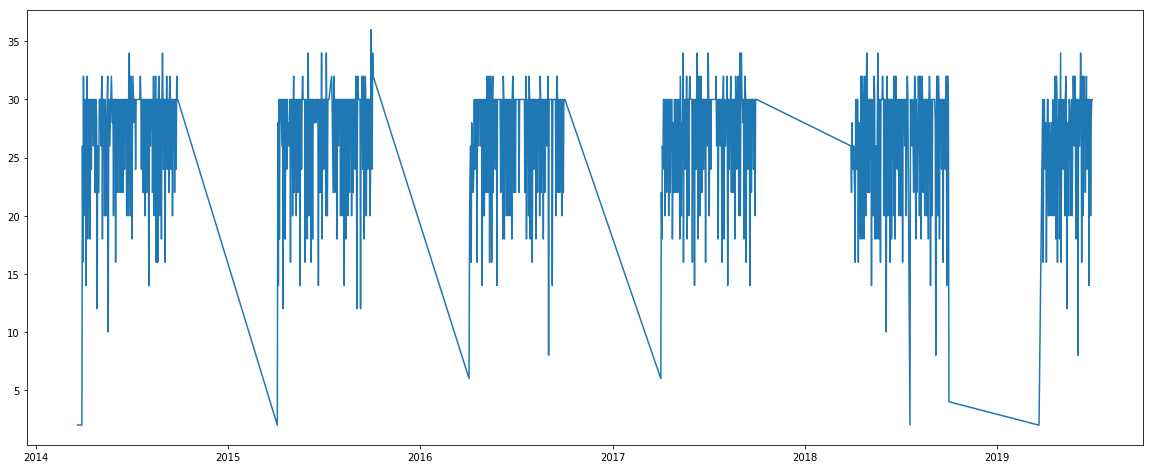

In [13]:
# time distribution - all data
plt.figure(figsize=(20,8)) 
plt.plot((data.groupby(['day_id'])['game_id'].count()));

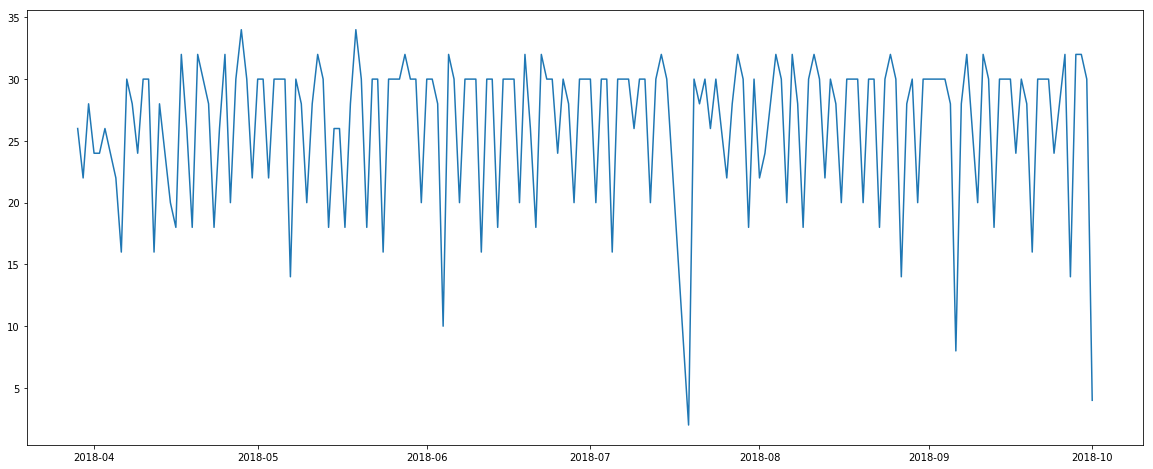

In [14]:
# time distribution - 2018
plt.figure(figsize=(20,8)) 
plt.plot(data[data['day_id'].dt.year==2018].groupby(['day_id'])['game_id'].count());

### Cross-validation assumption and pipeline

Data seasonality: from April to October each year, totally 5.5 years. Sliding window CV shall be used.

2019 samples will act as test set.

2018 samples will act as validation set

2014...2017 samples will be splitted to 3 1-year sets.

<b>CV scheme:</b>

1. Train on 2014, test on 2015.
2. Train on 2014+2015, test on 2016.
3. Train on 2014+2015+2016, test on 2017.


<b>Work pipeline:</b>

Prepare dataset for fit.

Get a baseline for given dataset on 2018 validation set.

Make feature engineering with CV.

Tune model params with CV.

Check model performance on 2018 validation set.

After feature engineering and model parameters tuning fit model with 2014...2018 data and predict 2019 results.

### Prepare dataset

#### Add features, separate target

In [15]:
# convert timestamp to separate features
data['year'] = data['day_id'].dt.year
data['month'] = data['day_id'].dt.month
data['day'] = data['day_id'].dt.day

# detach target column
y_train = data['fp0'].values

#### Store train-val-test indices

In [16]:
idx2014 = data[data['year']==2014].index.tolist()
idx2015 = data[data['year']==2015].index.tolist()
idx2016 = data[data['year']==2016].index.tolist()
idx2017 = data[data['year']==2017].index.tolist()

train_idx = data[data['year']<2018].index.tolist()

train_cv_idx = [idx2014, idx2015, idx2016, idx2017]

val_idx = data[data['year']==2018].index.tolist()

test_idx = data[data['year']==2019].index.tolist()

#### Scale data

In [17]:
data.head(10)

,day_id,game_id,player_id,fp0,is_home,age,height,weight,p_hand,p_days_since_last_game,...,win_sma90_pg,league_fp0_sma300_pd_pg,league_atbatallowed_sma450_pd_pp,hitsagainst_sma120_pg,league_walkallowed_sma150_pd_pp,swingingstrike_sma8100_pp,league_earnedruns_sma10_pd_pp,year,month,day
0,2014-03-22,36520,8973,27.40,False,26.0083,193,225,0,175.875,...,0.426080,14.052811,0.234136,5.446259,0.020534,0.110978,0.023832,2014,3,22
1,2014-03-22,36520,11523,18.25,True,27.3583,183,220,0,174.125,...,0.385982,14.052811,0.234136,6.085180,0.020534,0.086518,0.023832,2014,3,22
2,2014-03-23,36521,14901,23.45,False,26.9944,188,255,0,174.875,...,0.387422,14.054792,0.234142,5.954443,0.020541,0.089010,0.023754,2014,3,23
3,2014-03-23,36521,2401,-6.80,True,26.0611,193,240,1,177.750,...,0.349749,14.054792,0.234142,5.814777,0.020541,0.089942,0.023754,2014,3,23
4,2014-03-30,38221,14901,26.15,False,27.0139,188,255,0,7.250,...,0.394735,14.062742,0.234135,5.922135,0.020565,0.088985,0.023840,2014,3,30
5,2014-03-30,38221,2699,17.90,True,27.5528,198,220,1,189.167,...,0.339180,14.062742,0.234135,5.747135,0.020565,0.093642,0.023840,2014,3,30
6,2014-03-31,37978,6542,22.70,True,24.4000,178,190,1,183.208,...,0.364869,14.059320,0.234150,5.832381,0.020575,0.094187,0.023936,2014,3,31
7,2014-03-31,37978,10733,21.35,False,29.0250,198,260,1,183.292,...,0.371060,14.059320,0.234150,5.868976,0.020575,0.089724,0.023936,2014,3,31
8,2014-03-31,36522,2171,10.20,False,24.6667,196,235,0,193.333,...,0.426615,14.059320,0.234150,5.552310,0.020575,0.101340,0.023936,2014,3,31
9,2014-03-31,37897,6022,13.40,True,27.9250,185,205,1,185.750,...,0.358523,14.059320,0.234150,6.134310,0.020575,0.097672,0.023936,2014,3,31


In [18]:
# scaling all except first 4 columns
scaler = StandardScaler()
data[data.columns[4:]] = data[data.columns[4:]].astype('float64')
data[data.columns[4:]] = scaler.fit_transform(data[data.columns[4:]])

In [19]:
data.head(10)

,day_id,game_id,player_id,fp0,is_home,age,height,weight,p_hand,p_days_since_last_game,...,win_sma90_pg,league_fp0_sma300_pd_pg,league_atbatallowed_sma450_pd_pp,hitsagainst_sma120_pg,league_walkallowed_sma150_pd_pp,swingingstrike_sma8100_pp,league_earnedruns_sma10_pd_pp,year,month,day
0,2014-03-22,36520,8973,27.40,-1.0,-0.682536,0.520760,0.635852,-1.617347,0.824698,...,1.544302,-0.053558,0.616260,-0.856014,-0.477405,1.103418,-1.992987,-1.420986,-1.957372,0.679361
1,2014-03-22,36520,11523,18.25,1.0,-0.337095,-1.303803,0.413714,-1.617347,0.815353,...,0.704997,-0.053558,0.616260,1.483754,-0.477405,-1.175162,-1.992987,-1.420986,-1.957372,0.679361
2,2014-03-23,36521,14901,23.45,-1.0,-0.430211,-0.391521,1.968681,-1.617347,0.819358,...,0.735135,-0.048785,0.618600,1.004989,-0.469162,-0.943001,-2.032973,-1.420986,-1.957372,0.791596
3,2014-03-23,36521,2401,-6.80,1.0,-0.669026,0.520760,1.302267,0.618297,0.834712,...,-0.053419,-0.048785,0.618600,0.493521,-0.469162,-0.856133,-2.032973,-1.420986,-1.957372,0.791596
4,2014-03-30,38221,14901,26.15,-1.0,-0.425221,-0.391521,1.968681,-1.617347,-0.075829,...,0.888216,-0.029622,0.615661,0.886674,-0.441813,-0.945328,-1.988749,-1.420986,-1.957372,1.577237
5,2014-03-30,38221,2699,17.90,1.0,-0.287326,1.433042,0.413714,0.618297,0.895683,...,-0.274642,-0.029622,0.615661,0.245813,-0.441813,-0.511499,-1.988749,-1.420986,-1.957372,1.577237
6,2014-03-31,37978,6542,22.70,1.0,-1.094072,-2.216085,-0.919116,0.618297,0.863860,...,0.263061,-0.037870,0.621536,0.557988,-0.431012,-0.460765,-1.939546,-1.420986,-1.957372,1.689472
7,2014-03-31,37978,10733,21.35,-1.0,0.089384,1.433042,2.190819,0.618297,0.864308,...,0.392653,-0.037870,0.621536,0.692002,-0.431012,-0.876435,-1.939546,-1.420986,-1.957372,1.689472
8,2014-03-31,36522,2171,10.20,-1.0,-1.025828,1.068129,1.080128,-1.617347,0.917931,...,1.555511,-0.037870,0.621536,-0.467652,-0.431012,0.205584,-1.939546,-1.420986,-1.957372,1.689472
9,2014-03-31,37897,6022,13.40,1.0,-0.192086,-0.938891,-0.252701,0.618297,0.877435,...,0.130237,-0.037870,0.621536,1.663670,-0.431012,-0.136112,-1.939546,-1.420986,-1.957372,1.689472


In [20]:
# check data types
data.dtypes.unique()

array([dtype('<M8[ns]'), dtype('int64'), dtype('float64')], dtype=object)

In [21]:
# almost all data is numeric
data.columns[data.dtypes=='datetime64[ns]']

Index(['day_id'], dtype='object')

#### Add unique players pairs feature

In [22]:
# add unique players pairs
data['pair'] = data.groupby(['game_id'])['player_id'].transform(np.min).astype('str') + '_' + data.groupby('game_id')['player_id'].transform(np.max).astype('str')

#### OHE categorial features in separate DFs

In [23]:
# One-hot encoding of player pairs
pairs_df = pd.get_dummies(data['pair'], prefix='pair', sparse=True)
pairs_df.head(2)

,pair_1000_14739,pair_10027_10247,pair_10027_10733,pair_10027_10803,pair_10027_10841,pair_10027_11607,pair_10027_11986,pair_10027_12451,pair_10027_12495,pair_10027_12641,...,pair_9997_15199,pair_9997_15936,pair_9997_16738,pair_9997_16881,pair_9997_17406,pair_9997_17588,pair_9997_17708,pair_9997_18112,pair_9997_18578,pair_9997_18601
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# One-hot encoding of player_id
players_df = pd.get_dummies(data['player_id'], prefix='player', sparse=True)
players_df.head(2)

,player_60,player_108,player_142,player_143,player_156,player_176,player_273,player_274,player_313,player_318,...,player_19672,player_19675,player_19679,player_19683,player_19684,player_19687,player_19692,player_19695,player_19699,player_19700
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Drop columns which are not needed anymore, check data types

In [25]:
# drop not needed
deleted_features = data[['day_id', 'game_id', 'player_id', 'pair']].copy()
data.drop(['day_id', 'game_id', 'fp0', 'player_id', 'pair'], axis=1, inplace=True)

In [26]:
# only numeric dtypes now
data.dtypes.unique()

array([dtype('float64')], dtype=object)

#### Create sparce matrix with full data

In [27]:
data_csr = csr_matrix(hstack([data, players_df, pairs_df]))

In [28]:
data_csr

<26804x11877 sparse matrix of type '<class 'numpy.float64'>'
	with 16859716 stored elements in Compressed Sparse Row format>

### Get a baseline for given dataset on 2018 validation set

In [29]:
# train LGBM regressor with default params

device_type='gpu'  
num_boost_round = 10000
verbose_eval=10
early_stopping_rounds=10

params = {
            'random_state': 24,
            'device_type': device_type,
            'objective': 'root_mean_squared_error',
            'learning_rate': 0.05
         }

trn_data = lgb.Dataset(data_csr[train_idx, :], label=y_train[train_idx])
val_data = lgb.Dataset(data_csr[val_idx, :], label=y_train[val_idx])

clf = lgb.train(params, trn_data, num_boost_round=num_boost_round, valid_sets = [trn_data, val_data], 
                verbose_eval=verbose_eval, early_stopping_rounds=early_stopping_rounds)

Training until validation scores don't improve for 10 rounds.
[10]	training's rmse: 11.0796	valid_1's rmse: 11.0167
[20]	training's rmse: 10.8215	valid_1's rmse: 10.8731
[30]	training's rmse: 10.6503	valid_1's rmse: 10.8148
[40]	training's rmse: 10.5136	valid_1's rmse: 10.8311
Early stopping, best iteration is:
[32]	training's rmse: 10.6217	valid_1's rmse: 10.8082


In [30]:
y_pred = clf.predict(data_csr[val_idx, :], num_iteration=clf.best_iteration)

In [31]:
res = pd.DataFrame(y_pred, columns=['Predicted'])
res['Train'] = y_train[val_idx]
res.head()

,Predicted,Train
0,22.867807,29.10
1,12.781956,21.60
2,20.082313,28.35
3,11.675769,-4.80
4,15.294489,13.50


In [32]:
# set baseline 
baseline = clf.best_score['valid_1']['rmse']
baseline

10.808199487000483

### Basic feature engineering with CV

In [33]:
# can't use sklearn.model_selection.TimeSeriesSplit because of winter gaps in dataset, use own CV

def TimeCV(train_cv_idx, data_csr, params, num_boost_round=1000, verbose=0, early_stopping_rounds=10):
    
    train_indices = []
    
    for fold in range(0,3):

        train_indices.extend(train_cv_idx[fold])
        val_indices = train_cv_idx[fold+1]
        if verbose:
            print('Fold %i. Train size: %i, validaton size: %i' % (fold, len(train_indices), len(val_indices)))
        
        trn_data = lgb.Dataset(data_csr[train_indices, :], label=y_train[train_indices])
        val_data = lgb.Dataset(data_csr[val_indices, :], label=y_train[val_indices])

        clf = lgb.train(params, trn_data, num_boost_round=num_boost_round, valid_sets = [val_data], 
                        verbose_eval=verbose, early_stopping_rounds=early_stopping_rounds)
        
        best_score = clf.best_score['valid_0']['rmse']
        
        if verbose:
            print('Best score: %2.4f' % best_score)
    
    return best_score, clf.feature_importance()

In [34]:
score, importances = TimeCV(train_cv_idx, data_csr, params, num_boost_round, 100, early_stopping_rounds)

Fold 0. Train size: 4860, validaton size: 4858
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[28]	valid_0's rmse: 11.3932
Best score: 11.3932
Fold 1. Train size: 9718, validaton size: 4856
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[40]	valid_0's rmse: 11.0443
Best score: 11.0443
Fold 2. Train size: 14574, validaton size: 4860
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[66]	valid_0's rmse: 10.9372
Best score: 10.9372


In [35]:
fi = pd.DataFrame(index = np.hstack([data.columns, players_df.columns, pairs_df.columns]))
fi['Importance'] = importances
fi.sort_values(by='Importance', ascending=False, inplace=True)
print('Score:', score)
fi[fi['Importance']>0].head()

Score: 10.937197886055404


,Importance
is_home,53
strikeouts_sma6_pg,29
strikeouts_sma1350_pp,27
temp,25
windspeed,21


In [36]:
new_features = pd.DataFrame(index=data.index)

In [37]:
# add couple of features
new_features['pair_count'] = deleted_features['pair']
new_features['pair_count'] = new_features['pair_count'].map(new_features['pair_count'].value_counts())

In [38]:
new_features['pair_count_by_player_id'] = deleted_features['player_id']
new_features['pair_count_by_player_id'] = new_features.groupby(['pair_count_by_player_id'])['pair_count'].transform(np.sum)

In [39]:
new_features.head()

,pair_count,pair_count_by_player_id
0,4,648
1,4,508
2,2,308
3,2,164
4,2,308


In [40]:
new_features[:] = scaler.fit_transform(new_features[:])

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [41]:
data_csr = csr_matrix(hstack([data, players_df, pairs_df, new_features]))

In [42]:
score, importances = TimeCV(train_cv_idx, data_csr, params, num_boost_round, 100, early_stopping_rounds)

fi = pd.DataFrame(index = np.hstack([data.columns, players_df.columns, pairs_df.columns, new_features.columns]))
fi['Importance'] = importances
fi.sort_values(by='Importance', ascending=False, inplace=True)
print('Score:', score)
fi[fi['Importance']>0].head()

Fold 0. Train size: 4860, validaton size: 4858
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[36]	valid_0's rmse: 11.2493
Best score: 11.2493
Fold 1. Train size: 9718, validaton size: 4856
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[40]	valid_0's rmse: 10.9998
Best score: 10.9998
Fold 2. Train size: 14574, validaton size: 4860
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[46]	valid_0's rmse: 10.9131
Best score: 10.9131
Score: 10.913069666824915


,Importance
pair_count_by_player_id,106
is_home,43
strikeouts_sma1350_pp,33
temp,20
walkallowed_sma180_pp,17


### Tune model params with CV


In [43]:
device_type='gpu'  
num_boost_round = 10000
verbose_eval=10
early_stopping_rounds=10

# constant params
params = {
                'random_state': 24,
                'device_type': device_type,
                'objective': 'root_mean_squared_error',
                'learning_rate': 0.05
             }

# params for tuning
param_grid = {
             'num_leaves': np.linspace(800, 1200, 11).astype('int'),
             'min_child_weight': np.logspace(-3, 1, 11),
             'feature_fraction': np.linspace(0.05, 1, 11),
             'bagging_fraction': np.linspace(0.05, 1, 11),
             'min_data_in_leaf': np.linspace(0, 1000, 11).astype('int'),
             'max_depth': np.linspace(400, 1000, 11).astype('int'),
             'reg_alpha': np.logspace(-3, 1, 11),
             'reg_lambda': np.logspace(-3, 1, 11)
             }

In [44]:
# randomized params search
n_iter = 100

best_params = {}
best_score = 1e10

for i in range(n_iter):
    
    keys_idx = np.random.randint(0, 11, 8)
    num_param = 0
    for key in param_grid.keys():
        params[key] = param_grid[key][keys_idx[num_param]]
        num_param+=1
    
    score, _ = TimeCV(train_cv_idx, data_csr, params, num_boost_round, 0, early_stopping_rounds)
    
    print('Iteration %i, score %2.4f' % (i, score))
    
    if score<best_score:
        best_score = score
        best_params = params
        
best_score, best_params

Iteration 0, score 10.8805
Iteration 1, score 10.8928
Iteration 2, score 11.2787
Iteration 3, score 11.2906
Iteration 4, score 10.8647
Iteration 5, score 10.8750
Iteration 6, score 10.9214
Iteration 7, score 10.8602
Iteration 8, score 10.8758
Iteration 9, score 10.8606
Iteration 10, score 10.8908
Iteration 11, score 11.2405
Iteration 12, score 10.9098
Iteration 13, score 10.9196


KeyboardInterrupt: 

In [46]:
# best_params = { 
#   'random_state': 24,
#   'device_type': 'gpu',
#   'objective': 'root_mean_squared_error',
#   'learning_rate': 0.05,
#   'num_leaves': 840,
#   'min_child_weight': 0.039810717055349734,
#   'feature_fraction': 0.335,
#   'bagging_fraction': 0.14500000000000002,
#   'min_data_in_leaf': 500,
#   'max_depth': 820,
#   'reg_alpha': 0.25118864315095824,
#   'reg_lambda': 0.001}

### Check model performance on 2018 validation set

In [47]:
# decrease lr, increase early_stopping_rounds
num_boost_round = 100000
early_stopping_rounds = 50
best_params['learning_rate'] = 0.01

trn_data = lgb.Dataset(data_csr[train_idx, :], label=y_train[train_idx])
val_data = lgb.Dataset(data_csr[val_idx, :], label=y_train[val_idx])

clf = lgb.train(best_params, trn_data, num_boost_round=num_boost_round, valid_sets = [trn_data, val_data], 
                verbose_eval=1000, early_stopping_rounds=early_stopping_rounds)

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[377]	training's rmse: 10.3401	valid_1's rmse: 10.684


In [48]:
final_score = clf.best_score['valid_1']['rmse']
final_score

10.683954311682953

In [49]:
baseline

10.808199487000483

In [50]:
print('Total improvement is %2.4f ' % ((1-final_score/baseline)))

Total improvement is 0.0115 


### Fit model with 2014...2018 data and predict 2019 results.

In [51]:
# use 2018 data for score check
full_train_idx = train_idx.copy()
full_train_idx.extend(val_idx)

num_boost_round = 100000
early_stopping_rounds = 50
best_params['learning_rate'] = 0.01

trn_data = lgb.Dataset(data_csr[full_train_idx,:], label=y_train[full_train_idx])
val_data = lgb.Dataset(data_csr[val_idx, :], label=y_train[val_idx])

clf = lgb.train(best_params, trn_data, num_boost_round=num_boost_round, valid_sets = [trn_data, val_data], 
                verbose_eval=1000, early_stopping_rounds=early_stopping_rounds)

Training until validation scores don't improve for 50 rounds.
[1000]	training's rmse: 9.51445	valid_1's rmse: 9.37405
[2000]	training's rmse: 8.52296	valid_1's rmse: 8.42304
[3000]	training's rmse: 7.69798	valid_1's rmse: 7.62643
[4000]	training's rmse: 6.98888	valid_1's rmse: 6.94357
[5000]	training's rmse: 6.3708	valid_1's rmse: 6.34936
[6000]	training's rmse: 5.82544	valid_1's rmse: 5.82099
[7000]	training's rmse: 5.34156	valid_1's rmse: 5.35015
[8000]	training's rmse: 4.90906	valid_1's rmse: 4.92607
[9000]	training's rmse: 4.51792	valid_1's rmse: 4.54433
[10000]	training's rmse: 4.16662	valid_1's rmse: 4.2029
[11000]	training's rmse: 3.84655	valid_1's rmse: 3.89018
[12000]	training's rmse: 3.5606	valid_1's rmse: 3.60887
[13000]	training's rmse: 3.29943	valid_1's rmse: 3.35112
[14000]	training's rmse: 3.061	valid_1's rmse: 3.11774
[15000]	training's rmse: 2.84438	valid_1's rmse: 2.90371
[16000]	training's rmse: 2.64539	valid_1's rmse: 2.70392
[17000]	training's rmse: 2.46752	valid_1

In [52]:
# predict 2018 for test
y_pred = clf.predict(data_csr[val_idx, :])

res = pd.DataFrame(index=deleted_features.index[val_idx])
res['player_id'] = deleted_features['player_id'][val_idx]
res['game_id'] = deleted_features['game_id'][val_idx]
res['Predicted'] = y_pred
res['Ground truth'] = y_train[val_idx]
res.sort_values(by=['player_id', 'game_id'], inplace=True)
res

,player_id,game_id,Predicted,Ground truth
21112,176,46998,1.818126,1.80
20323,313,46596,14.665209,14.65
20445,313,46663,-15.065486,-15.05
20618,313,46752,5.223080,5.25
20723,313,46810,1.065337,1.05
22120,313,47490,18.217540,18.25
22274,313,47583,-1.867243,-1.90
22419,313,47647,20.693286,20.70
22543,313,47724,2.090430,2.10
22712,313,47794,17.948933,17.95


In [53]:
# predict 2019
y_pred = clf.predict(data_csr[test_idx, :])

res = pd.DataFrame(index=deleted_features.index[test_idx])
res['game_id'] = deleted_features['game_id'][test_idx]
res['player_id'] = deleted_features['player_id'][test_idx]
res['predfp0'] = y_pred
res.sort_values(by=['player_id', 'game_id'], inplace=True)
res

,game_id,player_id,predfp0
26127,49511,60,6.251195
26215,49559,60,8.497514
26018,49442,274,4.323340
24353,48625,313,8.438799
24489,48682,313,5.755958
24618,48742,313,7.042849
24748,48808,313,7.136052
24938,48907,313,8.952503
25070,48982,313,3.458494
25228,49054,313,6.821108


In [54]:
res.to_csv('predicted2019.csv')